# Objective
The goal of this project is to build a machine learning model that can detect anomalies in time-series data—basically spotting unusual patterns that don’t follow the normal trend. I chose Isolation Forest for this project.

# Dataset
For this, I’m using the Numenta Anomaly Benchmark (NAB) dataset, which you can find [here](https://github.com/numenta/NAB). Specifically, I’ll be working with the *machine_temperature_system_failure.csv* file from the ***realKnownCause*** category. This dataset tracks temperature readings from a machine over time and includes labeled anomalies caused by system failures. The data has timestamps and temperature values, and the actual anomaly windows are provided in a separate JSON file.

First, I cloned dataset.

In [1]:
!git clone https://github.com/numenta/NAB.git

Cloning into 'NAB'...
remote: Enumerating objects: 7119, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 7119 (delta 65), reused 34 (delta 19), pack-reused 6942 (from 2)
Receiving objects: 100% (7119/7119), 86.82 MiB | 9.17 MiB/s, done.
Resolving deltas: 100% (4944/4944), done.
Updating files: 100% (1186/1186), done.


# Data Preprocessing


> Import all necessary libraries.

> **Loading and Cleaning the Dataset**

> **Load** the dataset and its corresponding anomaly labels.



In [2]:
import pandas as pd
import numpy as np
import json
import time
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score

In [3]:
# Load the time-series data
data_path = 'NAB/data/realKnownCause/machine_temperature_system_failure.csv'
data = pd.read_csv(data_path)
print(data.head(), "\n", "Shape of Data:", data.shape)
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Load anomaly labels
labels_path = 'NAB/labels/combined_windows.json'
with open(labels_path, 'r') as f:
    labels = json.load(f)
anomaly_windows = labels['realKnownCause/machine_temperature_system_failure.csv']
anomaly_windows = [[pd.to_datetime(start), pd.to_datetime(end)] for start, end in anomaly_windows]

# Create a label column (1 for anomaly, 0 for normal)
data['label'] = 0
for start, end in anomaly_windows:
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 1


# Handling Missing Values
print("\n","Missing values in dataset: ")
print(data.isnull().sum())

             timestamp      value
0  2013-12-02 21:15:00  73.967322
1  2013-12-02 21:20:00  74.935882
2  2013-12-02 21:25:00  76.124162
3  2013-12-02 21:30:00  78.140707
4  2013-12-02 21:35:00  79.329836 
 Shape of Data: (22695, 2)

 Missing values in dataset: 
timestamp    0
value        0
label        0
dtype: int64


## Normalization
Normalization is beneficial for models sensitive to scale. I standardize the temperature values (value column) using StandardScaler.

In [4]:
scaler = StandardScaler()
data['value_scaled'] = scaler.fit_transform(data[['value']])

## Exploratory Data Analysis (EDA)
To understand the data, I visualize the time series and examine basic statistics.

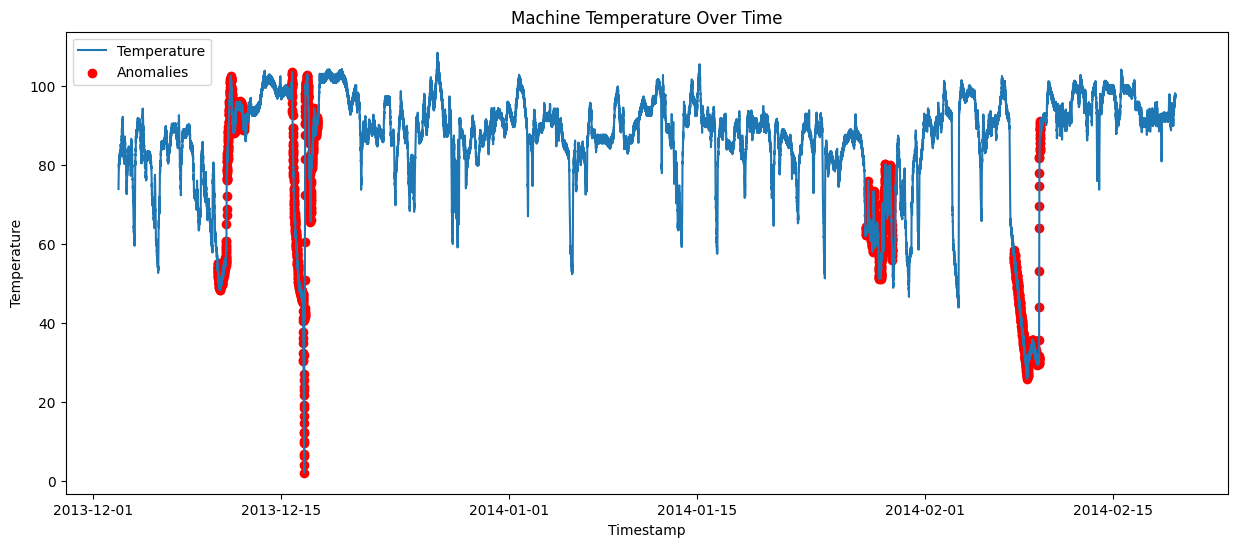

count    22695.000000
mean        85.926498
std         13.746912
min          2.084721
25%         83.080078
50%         89.408246
75%         94.016252
max        108.510543
Name: value, dtype: float64


In [5]:

plt.figure(figsize=(15, 6))
plt.plot(data['timestamp'], data['value'], label='Temperature')
plt.scatter(data['timestamp'][data['label'] == 1], data['value'][data['label'] == 1],
            color='red', label='Anomalies')
plt.title('Machine Temperature Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.show()

print(data['value'].describe())

# Feature Engineering
For the Isolation Forest, I extract additional features to capture temporal patterns:

Rolling Mean: Average temperature over a window.

Rolling Standard Deviation: Variability within a window.





In [6]:
window_size = 10
data['rolling_mean'] = data['value'].rolling(window=window_size).mean()
data['rolling_std'] = data['value'].rolling(window=window_size).std()

# Drop rows with NaN values due to rolling window
data = data.dropna().reset_index(drop=True)

# Model Selection & Training
I split the data into training (first 80%) and testing (last 20%) sets, preserving temporal order.

In [7]:
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:].reset_index(drop=True)

## Isolation Forest

Isolation Forest is an efficient, tree-based method for anomaly detection, suitable for univariate or multivariate data.

Feature Preparation

I use value, rolling_mean, and rolling_std as features.

In [8]:
features = ['value', 'rolling_mean', 'rolling_std']
train_features = scaler.fit_transform(train_data[features])
test_features = scaler.transform(test_data[features])

### Training

In [9]:
model_if = IsolationForest(contamination=0.01, n_estimators=100, n_jobs=-1, verbose=1, random_state=42)
# Train with timing
start_time = time.time()
model_if.fit(train_features)
print(f"Training time: {time.time() - start_time:.2f} seconds")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Training time: 0.55 seconds


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


In [10]:
test_pred_if = model_if.predict(test_features)
test_pred_if = np.where(test_pred_if == -1, 1, 0)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


# Evaluation

I evaluate both models using precision, recall, F1-score, ROC-AUC, and confusion matrix on the test set.


**Isolation Forest Evaluation**

True Anomalies: 567 out of 4538 (12.49%)
Precision: 0.9933
Recall: 0.7866
F1-score: 0.8780
ROC-AUC: 0.8929
Specificity: 0.9992
Confusion Matrix:
  True Negatives (TN): 3968
  False Positives (FP): 3
  False Negatives (FN): 121
  True Positives (TP): 446


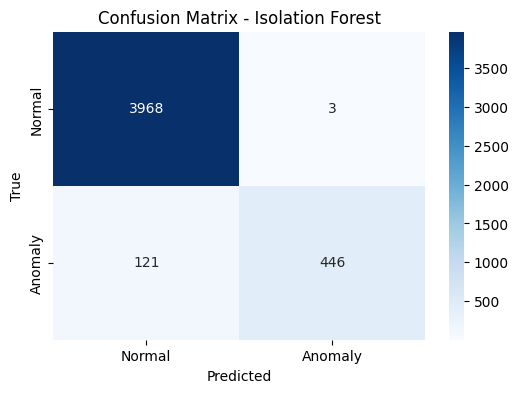

In [11]:
y_true = test_data['label'].values
y_pred_if = test_pred_if

# Check lengths
if len(y_true) != len(y_pred_if):
    raise ValueError(f"Length mismatch: y_true ({len(y_true)}) vs y_pred_if ({len(y_pred_if)})")

# Calculate class distribution
print(f"True Anomalies: {np.sum(y_true)} out of {len(y_true)} ({np.mean(y_true)*100:.2f}%)")

# Calculate metrics with error handling
try:
    cm = confusion_matrix(y_true, y_pred_if)
    tn, fp, fn, tp = cm.ravel()
    metrics_if = {
        'Precision': precision_score(y_true, y_pred_if),
        'Recall': recall_score(y_true, y_pred_if),
        'F1-score': f1_score(y_true, y_pred_if),
        'ROC-AUC': roc_auc_score(y_true, y_pred_if),
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'Confusion Matrix': cm
    }
except ValueError as e:
    print(f"Error calculating metrics: {e}")
    metrics_if = {}

# Print metrics
for key, value in metrics_if.items():
    if key == 'Confusion Matrix':
        print(f"{key}:")
        print(f"  True Negatives (TN): {tn}")
        print(f"  False Positives (FP): {fp}")
        print(f"  False Negatives (FN): {fn}")
        print(f"  True Positives (TP): {tp}")
    else:
        print(f"{key}: {value:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Isolation Forest')
plt.show()

# Visualization

I plot the time series with true and predicted anomalies for both models.


**Isolation Forest**

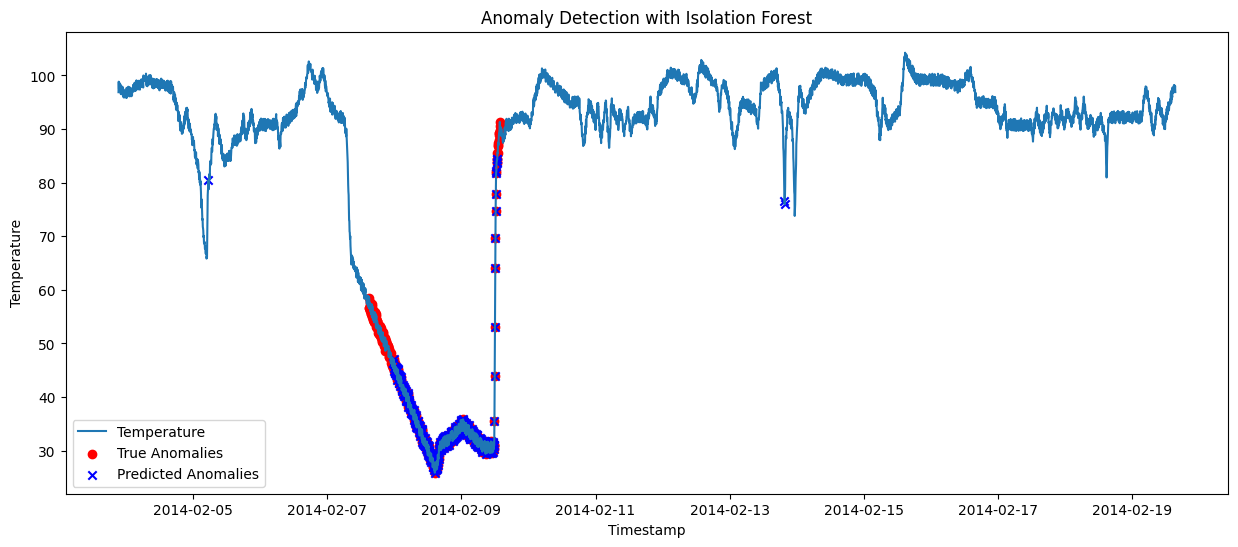

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(test_data['timestamp'], test_data['value'], label='Temperature')
plt.scatter(test_data['timestamp'][y_true == 1], test_data['value'][y_true == 1],
            color='red', label='True Anomalies')
plt.scatter(test_data['timestamp'][y_pred_if == 1], test_data['value'][y_pred_if == 1],
            color='blue', marker='x', label='Predicted Anomalies')
plt.title('Anomaly Detection with Isolation Forest')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Trained Model Files

Isolation Forest: Saved using joblib

In [13]:
import joblib
joblib.dump(model_if, 'isolation_forest_model.pkl')

['isolation_forest_model.pkl']

Test this model

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


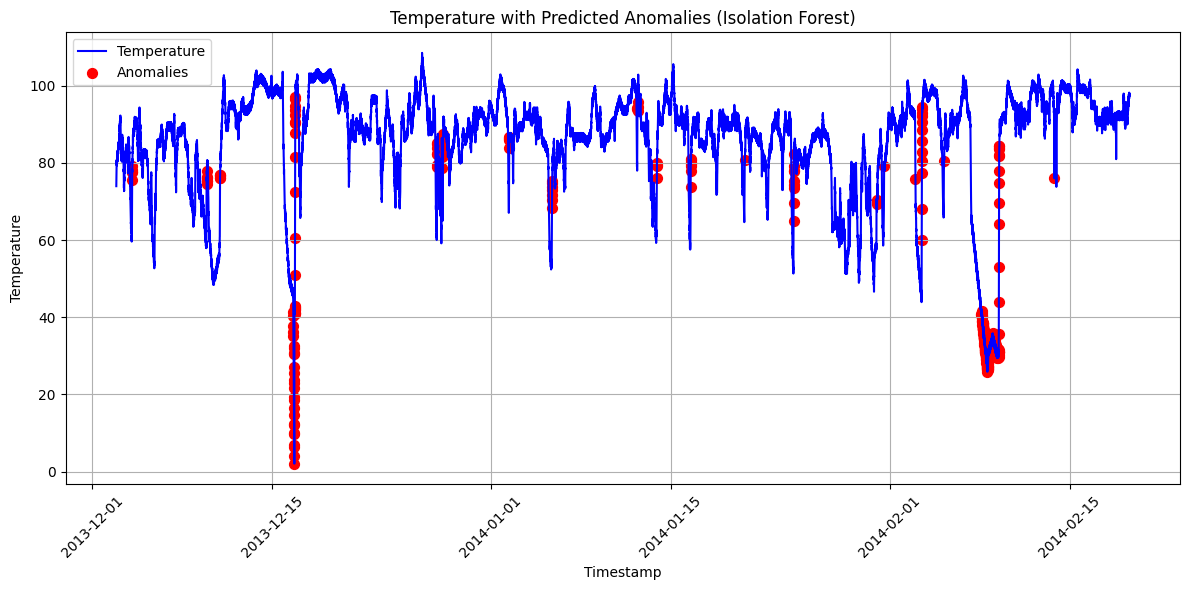

In [14]:
# Load the Trained Isolation Forest Model
model = joblib.load("isolation_forest_model.pkl")


# Load Test Data
file_path = "NAB/data/realKnownCause/machine_temperature_system_failure.csv"
test_df = pd.read_csv(file_path)
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

# Feature Engineering (Rolling Stats)
window_size = 10
test_df["rolling_mean"] = test_df["value"].rolling(window=window_size, min_periods=1).mean()
test_df["rolling_std"] = test_df["value"].rolling(window=window_size, min_periods=1).std()
test_df.fillna(0, inplace=True)

scaler = StandardScaler()
scaler.fit(test_df[["value", "rolling_mean", "rolling_std"]])
# Transform Features
test_features = scaler.transform(test_df[["value", "rolling_mean", "rolling_std"]])

# Batch Prediction
predictions = model.predict(test_features)
test_df["prediction"] = np.where(predictions == -1, "Anomaly", "Normal")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(test_df["timestamp"], test_df["value"], label="Temperature", color="blue")
plt.scatter(test_df["timestamp"][test_df["prediction"] == "Anomaly"],
            test_df["value"][test_df["prediction"] == "Anomaly"],
            color="red", label="Anomalies", s=50)
plt.title("Temperature with Predicted Anomalies (Isolation Forest)")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
import queue
import threading

# Load Pre-trained Model and Scaler
try:
    model = joblib.load("isolation_forest_model.pkl")
    print("Model loaded successfully!")
except FileNotFoundError:
    raise FileNotFoundError("Model file not found! Ensure 'isolation_forest_model.pkl' exists.")

try:
    scaler = joblib.load("scaler.pkl")
    print("Scaler loaded successfully!")
except FileNotFoundError:
    print("Scaler not found. Using new scaler (not ideal).")
    scaler = StandardScaler()
    scaler.fit(test_df[["value", "rolling_mean", "rolling_std"]])
    joblib.dump(scaler, "scaler.pkl")

#  Anomaly Detector with Rolling Features
class AnomalyDetector:
    def __init__(self, model, scaler, window_size=10):
        self.model = model
        self.scaler = scaler
        self.window_size = window_size
        self.buffer = []

    def update_buffer(self, value):
        self.buffer.append(value)
        if len(self.buffer) > self.window_size:
            self.buffer.pop(0)

    def compute_features(self):
        if len(self.buffer) < self.window_size:
            return None
        df = pd.Series(self.buffer)
        return np.array([[df.iloc[-1], df.mean(), df.std()]])

    def predict(self, value):
        self.update_buffer(value)
        features = self.compute_features()
        if features is None:
            return 1
        try:
            scaled_features = self.scaler.transform(features)
            return self.model.predict(scaled_features)[0]
        except Exception as e:
            print(f"Prediction error: {e}")
            return 1

# Fake Sensor Data Generator
def data_producer(queue):
    base_temp = 70
    while True:
        noise = np.random.normal(0, 5)
        temp = base_temp + noise + (time.time() % 100 > 95) * 20
        data = {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "temperature": temp
        }
        try:
            queue.put(data, timeout=1)
            print(f"Sent: {data['timestamp']} - {data['temperature']:.2f}°C")
        except queue.Full:
            print("Queue full, skipping data...")
        time.sleep(1)

# Anomaly Detector Consumer
def data_consumer(queue, detector, log_file="anomalies.txt"):
    with open(log_file, 'a') as f:
        while True:
            try:
                data = queue.get(timeout=5)
                anomaly = detector.predict(data["temperature"])
                result = f"{' Anomaly Detected!' if anomaly == -1 else ' Normal'}: " \
                         f"{data['timestamp']} - Temp: {data['temperature']:.2f}°C\n"
                print(result.strip())
                if anomaly == -1:
                    f.write(result)
                queue.task_done()
            except queue.Empty:
                print(" Queue empty, waiting for data...")
            except Exception as e:
                print(f" Consumer error: {e}")

# Run Producer and Consumer in Parallel
data_queue = queue.Queue(maxsize=100)
detector = AnomalyDetector(model, scaler)

producer_thread = threading.Thread(target=data_producer, args=(data_queue,), daemon=True)
consumer_thread = threading.Thread(target=data_consumer, args=(data_queue, detector), daemon=True)

producer_thread.start()
consumer_thread.start()

# Keep Script Running & Handle Exit Gracefully
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\n Stopping threads safely...")

Model loaded successfully!
Scaler loaded successfully!
Sent: 2025-02-28 12:57:02 - 66.86°C
Normal: 2025-02-28 12:57:02 - Temp: 66.86°C
Sent: 2025-02-28 12:57:02 - 75.71°C
Normal: 2025-02-28 12:57:02 - Temp: 75.71°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:03 - 64.52°C
Normal: 2025-02-28 12:57:03 - Temp: 64.52°C
Sent: 2025-02-28 12:57:03 - 62.55°C
Normal: 2025-02-28 12:57:03 - Temp: 62.55°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:04 - 66.09°C
Normal: 2025-02-28 12:57:04 - Temp: 66.09°C
Sent: 2025-02-28 12:57:04 - 75.45°C
Normal: 2025-02-28 12:57:04 - Temp: 75.45°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:05 - 64.20°C
Normal: 2025-02-28 12:57:05 - Temp: 64.20°C
Sent: 2025-02-28 12:57:05 - 67.83°C
Normal: 2025-02-28 12:57:05 - Temp: 67.83°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:06 - 65.94°C
Normal: 2025-02-28 12:57:06 - Temp: 65.94°C
Sent: 2025-02-28 12:57:06 - 63.49°C
Anomaly Detected!: 2025-02-28 12:57:06 - Temp: 63.49°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:07 - 64.64°C
Normal: 2025-02-28 12:57:07 - Temp: 64.64°C
Sent: 2025-02-28 12:57:07 - 67.69°C
Normal: 2025-02-28 12:57:07 - Temp: 67.69°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:08 - 71.13°CNormal: 2025-02-28 12:57:08 - Temp: 71.13°C

Sent: 2025-02-28 12:57:08 - 66.98°C
Normal: 2025-02-28 12:57:08 - Temp: 66.98°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:09 - 64.66°CNormal: 2025-02-28 12:57:09 - Temp: 64.66°C

Sent: 2025-02-28 12:57:09 - 76.64°C
Normal: 2025-02-28 12:57:09 - Temp: 76.64°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:10 - 68.04°CNormal: 2025-02-28 12:57:10 - Temp: 68.04°C

Sent: 2025-02-28 12:57:10 - 79.76°C
Anomaly Detected!: 2025-02-28 12:57:10 - Temp: 79.76°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:11 - 68.33°C
Normal: 2025-02-28 12:57:11 - Temp: 68.33°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:11 - 68.45°C
Anomaly Detected!: 2025-02-28 12:57:11 - Temp: 68.45°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:12 - 77.42°C
Normal: 2025-02-28 12:57:12 - Temp: 77.42°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:12 - 66.65°C
Anomaly Detected!: 2025-02-28 12:57:12 - Temp: 66.65°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:13 - 61.09°C
Normal: 2025-02-28 12:57:13 - Temp: 61.09°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Sent: 2025-02-28 12:57:13 - 69.70°C
Normal: 2025-02-28 12:57:13 - Temp: 69.70°C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s



 Stopping threads safely...
